# 第一课 当深度学习遇上PyTorch

## 一、有关Tensor和Autograd变量的练习
### 1. Tensor
#### a. 产生Tensor

In [2]:
import torch  #导入torch包

In [290]:
x = torch.rand(5, 3)  #产生一个5*3的tensor，随机取值
x  #显示x的值


 0.8727  0.2070  0.1723
 0.8514  0.1200  0.2209
 0.2763  0.4250  0.4406
 0.9294  0.7216  0.6987
 0.7218  0.9581  0.8032
[torch.FloatTensor of size 5x3]

In [307]:
y = torch.ones(5, 3) #产生一个5*3的Tensor，元素都是1
y


 1  1  1
 1  1  1
 1  1  1
 1  1  1
 1  1  1
[torch.FloatTensor of size 5x3]

#### b. Tensor的运算

In [308]:
z = x + y #两个tensor可以直接相加
z


 1.8727  1.2070  1.1723
 1.8514  1.1200  1.2209
 1.2763  1.4250  1.4406
 1.9294  1.7216  1.6987
 1.7218  1.9581  1.8032
[torch.FloatTensor of size 5x3]

下面的语句展示了两个tensor按照矩阵的方式相乘，注意x的尺寸是5*3，y的尺寸也是5*3无法进行矩阵乘法，所以先将y进行转置。
转置操作可以用.t来完成，也可以用<!-- lang:python-->.transpose(0, 1)来完成

In [309]:
q = x.mm(y.t) #x乘以y的转置
q


 1.2520  1.2520  1.2520  1.2520  1.2520
 1.1923  1.1923  1.1923  1.1923  1.1923
 1.1419  1.1419  1.1419  1.1419  1.1419
 2.3497  2.3497  2.3497  2.3497  2.3497
 2.4831  2.4831  2.4831  2.4831  2.4831
[torch.FloatTensor of size 5x5]

#### c. Tensor与numpy.ndarray之间的转换

In [310]:
import numpy as np #导入numpy包
a = np.ones([5, 3]) #建立一个5*3全是1的二维数组（矩阵）
b = torch.from_numpy(a) #利用from_numpy将其转换为tensor
b


 1  1  1
 1  1  1
 1  1  1
 1  1  1
 1  1  1
[torch.DoubleTensor of size 5x3]

In [311]:
c = torch.FloatTensor(a) #另外一种转换为tensor的方法，类型为FloatTensor，还可以使LongTensor，整型数据类型
c


 1  1  1
 1  1  1
 1  1  1
 1  1  1
 1  1  1
[torch.FloatTensor of size 5x3]

In [312]:
b.numpy()  #从一个tensor转化为numpy的多维数组

array([[ 1.,  1.,  1.],
       [ 1.,  1.,  1.],
       [ 1.,  1.,  1.],
       [ 1.,  1.,  1.],
       [ 1.,  1.,  1.]])

tensor和numpy的最大区别在于tensor可以在GPU上运算

In [313]:
if torch.cuda.is_available():  #检测本机器上有无GPU可用
    x = x.cuda() #返回x的GPU上运算的版本
    y = y.cuda()
    print(x + y) #tensor可以在GPU上正常运算

### 2. 有关自动微分变量

In [3]:
from torch.autograd import Variable  #导入自动梯度的运算包，主要用Variable这个类

In [315]:
x = Variable(torch.ones(2, 2), requires_grad=True)  #创建一个Variable，包裹了一个2*2张量，将需要计算梯度属性置为True
x

Variable containing:
 1  1
 1  1
[torch.FloatTensor of size 2x2]

In [316]:
y = x + 2  #可以按照Tensor的方式进行计算
y.creator  #每个Variable都有一个creator（创造者节点）

In [317]:
z = y * y  #可以进行各种符合运算
z.creator

**注意，.data可以反回一个Variable所包裹的Tensor**

In [318]:
z = torch.mean(y * y)  #也可以进行复合运算
z.data #.data属性可以返回z所包裹的tensor


 9
[torch.FloatTensor of size 1]

** backward可以实施反向传播算法，并计算所有计算图上叶子节点的导数（梯度）信息。注意，由于z和y都不是叶子节点，所以都没有梯度信息）**

In [319]:
z.backward() #梯度反向传播
print(z.grad)
print(y.grad)
print(x.grad)

None
None
Variable containing:
 1.5000  1.5000
 1.5000  1.5000
[torch.FloatTensor of size 2x2]



在下面的例子中，我们让矩阵x反复作用在向量x上，系统会自动记录中间的依赖关系和长路径

In [320]:
s = Variable(torch.FloatTensor([[0.01, 0.02]]), requires_grad = True) #创建一个1*2的Variable（1维向量）
x = Variable(torch.ones(2, 2), requires_grad = True) #创建一个2*2的矩阵型Variable
for i in range(10):
    s = s.mm(x)  #反复用s乘以x（矩阵乘法），注意s始终是1*2的Variable
z = torch.mean(s) #对s中的各个元素求均值，得到一个1*1的scalar（标量，即1*1张量）

In [321]:
z.backward() #在具有很长的依赖路径的计算图上用反向传播算法计算叶节点的梯度
print(x.grad)  #x作为叶节点可以获得这部分梯度信息
print(s.grad)  #s不是叶节点，没有梯度信息

Variable containing:
 37.1200  37.1200
 39.6800  39.6800
[torch.FloatTensor of size 2x2]

None


## 二、利用PyTorch实现简单的线性回归算法

### 1. 准备数据

在这里，我们人为生成一些样本点作为我们的原始数据

In [5]:
x = Variable(torch.linspace(0, 100).type(torch.FloatTensor)) #linspace可以生成0-100之间的均匀的100个数字
rand = Variable(torch.randn(100)) * 10 #随机生成100个满足标准正态分布的随机数，均值为0，方差为1.将这个数字乘以10，标准方差变为10
y = x + rand #将x和rand相加，得到伪造的标签数据y。所以(x,y)应能近似地落在y=x这条直线上

将生成的原始数据点画在图上

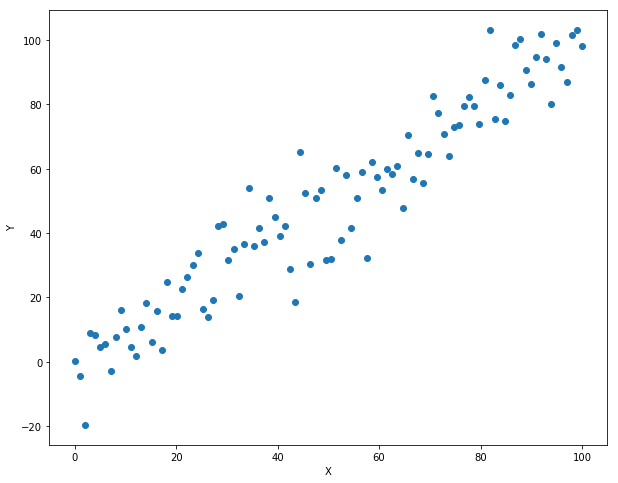

In [6]:
import matplotlib.pyplot as plt #导入画图的程序包
plt.figure(figsize=(10,8)) #设定绘制窗口大小为10*8 inch
plt.plot(x.data.numpy(), y.data.numpy(), 'o') #绘制数据，考虑到x和y都是Variable，需要用data获取它们包裹的Tensor，并专成numpy
plt.xlabel('X') #添加X轴的标注
plt.ylabel('Y') #添加Y周的标注
plt.show() #将图形画在下面

### 2. 构造模型，计算损失函数

在下面的代码中，需要注意expand_as和mul的使用。首先，a的维度为1，x的维度为100*1的Tensor，这两者不能直接相乘，因为维度不同。

所以，先要将a升维成1*1的Tensor。这就好比将原本在直线上的点被升维到了二维平面上，同时直线仍然在二维平面中。

```expand_as(x)```可以将张量升维成与x同维度的张量。所以如果a = 1, x为尺寸为100，那么，

a.expand_as(x)$ = (1, 1, \cdot\cdot\cdot, 1)^T$

```x * y```为两个1维张量的乘积，计算结果：

$(x * y)_i = x_i \cdot y_i$

In [7]:
a = Variable(torch.rand(1), requires_grad = True)
b = Variable(torch.rand(1), requires_grad = True)
predictions = a.expand_as(x) * x + b.expand_as(x)
predictions

Variable containing:
  0.1503
  0.4517
  0.7531
  1.0545
  1.3560
  1.6574
  1.9588
  2.2602
  2.5616
  2.8630
  3.1644
  3.4658
  3.7672
  4.0686
  4.3701
  4.6715
  4.9729
  5.2743
  5.5757
  5.8771
  6.1785
  6.4799
  6.7813
  7.0827
  7.3842
  7.6856
  7.9870
  8.2884
  8.5898
  8.8912
  9.1926
  9.4940
  9.7954
 10.0968
 10.3983
 10.6997
 11.0011
 11.3025
 11.6039
 11.9053
 12.2067
 12.5081
 12.8095
 13.1109
 13.4124
 13.7138
 14.0152
 14.3166
 14.6180
 14.9194
 15.2208
 15.5222
 15.8236
 16.1250
 16.4265
 16.7279
 17.0293
 17.3307
 17.6321
 17.9335
 18.2349
 18.5363
 18.8377
 19.1391
 19.4405
 19.7420
 20.0434
 20.3448
 20.6462
 20.9476
 21.2490
 21.5504
 21.8518
 22.1532
 22.4546
 22.7561
 23.0575
 23.3589
 23.6603
 23.9617
 24.2631
 24.5645
 24.8659
 25.1673
 25.4687
 25.7702
 26.0716
 26.3730
 26.6744
 26.9758
 27.2772
 27.5786
 27.8800
 28.1814
 28.4828
 28.7843
 29.0857
 29.3871
 29.6885
 29.9899
[torch.FloatTensor of size 100]

In [8]:
loss = torch.mean((predictions - y) ** 2)  #计算损失函数
loss.backward() #开始反向传播梯度


In [9]:
#开始梯度下降，其中0.001为学习率
a.data.add_(- 0.001 * a.grad.data) 
b.data.add_(- 0.001 * b.grad.data)

#注意我们无法改变一个Variable，而只能对Variable的data属性做更改
#所有函数加“_”都意味着需要更新调用者的数值。


 0.2177
[torch.FloatTensor of size 1]

### 3. 训练模型的代码

#### a. 错误版本

In [336]:
a = Variable(torch.rand(1), requires_grad = True)
b = Variable(torch.rand(1), requires_grad = True)
print('Initial parameters:', parameters)
learning_rate = 0.0001
for i in range(1000):
    predictions = a.expand_as(x).mul(x)+ b.expand_as(x)
    loss = torch.mean((predictions - y) ** 2)
    print('loss:', loss)
    loss.backward()
    a.data.add_(- learning_rate * a.grad.data)
    b.data.add_(- learning_rate * b.grad.data)

Initial parameters: Variable containing:
 0.9360
-1.2649
[torch.FloatTensor of size 2]

loss: Variable containing:
 891.9670
[torch.FloatTensor of size 1]

loss: Variable containing:
 174.1016
[torch.FloatTensor of size 1]

loss: Variable containing:
 340.3487
[torch.FloatTensor of size 1]

loss: Variable containing:
 1019.7123
[torch.FloatTensor of size 1]

loss: Variable containing:
 696.1315
[torch.FloatTensor of size 1]

loss: Variable containing:
 91.7018
[torch.FloatTensor of size 1]

loss: Variable containing:
 555.2567
[torch.FloatTensor of size 1]

loss: Variable containing:
 1052.3289
[torch.FloatTensor of size 1]

loss: Variable containing:
 473.6536
[torch.FloatTensor of size 1]

loss: Variable containing:
 110.5886
[torch.FloatTensor of size 1]

loss: Variable containing:
 773.3381
[torch.FloatTensor of size 1]

loss: Variable containing:
 982.9115
[torch.FloatTensor of size 1]

loss: Variable containing:
 271.6191
[torch.FloatTensor of size 1]

loss: Variable containing:


loss: Variable containing:
 1048.7905
[torch.FloatTensor of size 1]

loss: Variable containing:
 458.8982
[torch.FloatTensor of size 1]

loss: Variable containing:
 112.5044
[torch.FloatTensor of size 1]

loss: Variable containing:
 782.6674
[torch.FloatTensor of size 1]

loss: Variable containing:
 973.9118
[torch.FloatTensor of size 1]

loss: Variable containing:
 259.5104
[torch.FloatTensor of size 1]

loss: Variable containing:
 233.7633
[torch.FloatTensor of size 1]

loss: Variable containing:
 954.1790
[torch.FloatTensor of size 1]

loss: Variable containing:
 813.1396
[torch.FloatTensor of size 1]

loss: Variable containing:
 125.4389
[torch.FloatTensor of size 1]

loss: Variable containing:
 425.7930
[torch.FloatTensor of size 1]

loss: Variable containing:
 1043.9880
[torch.FloatTensor of size 1]

loss: Variable containing:
 600.5209
[torch.FloatTensor of size 1]

loss: Variable containing:
 85.0798
[torch.FloatTensor of size 1]

loss: Variable containing:
 647.9689
[torch.Flo


loss: Variable containing:
 1049.6980
[torch.FloatTensor of size 1]

loss: Variable containing:
 573.2959
[torch.FloatTensor of size 1]

loss: Variable containing:
 88.5947
[torch.FloatTensor of size 1]

loss: Variable containing:
 677.2029
[torch.FloatTensor of size 1]

loss: Variable containing:
 1025.5460
[torch.FloatTensor of size 1]

loss: Variable containing:
 356.2213
[torch.FloatTensor of size 1]

loss: Variable containing:
 162.8396
[torch.FloatTensor of size 1]

loss: Variable containing:
 876.9031
[torch.FloatTensor of size 1]

loss: Variable containing:
 904.8713
[torch.FloatTensor of size 1]

loss: Variable containing:
 184.2843
[torch.FloatTensor of size 1]

loss: Variable containing:
 323.1474
[torch.FloatTensor of size 1]

loss: Variable containing:
 1011.5281
[torch.FloatTensor of size 1]

loss: Variable containing:
 713.1979
[torch.FloatTensor of size 1]

loss: Variable containing:
 93.8583
[torch.FloatTensor of size 1]

loss: Variable containing:
 535.5710
[torch.Fl

loss: Variable containing:
 701.1793
[torch.FloatTensor of size 1]

loss: Variable containing:
 91.9472
[torch.FloatTensor of size 1]

loss: Variable containing:
 548.6672
[torch.FloatTensor of size 1]

loss: Variable containing:
 1052.1719
[torch.FloatTensor of size 1]

loss: Variable containing:
 478.8892
[torch.FloatTensor of size 1]

loss: Variable containing:
 108.1907
[torch.FloatTensor of size 1]

loss: Variable containing:
 767.3632
[torch.FloatTensor of size 1]

loss: Variable containing:
 985.4467
[torch.FloatTensor of size 1]

loss: Variable containing:
 275.8093
[torch.FloatTensor of size 1]

loss: Variable containing:
 222.1077
[torch.FloatTensor of size 1]

loss: Variable containing:
 944.2207
[torch.FloatTensor of size 1]

loss: Variable containing:
 830.7295
[torch.FloatTensor of size 1]

loss: Variable containing:
 134.9375
[torch.FloatTensor of size 1]

loss: Variable containing:
 409.6022
[torch.FloatTensor of size 1]

loss: Variable containing:
 1041.8225
[torch.Flo

通过打印输出的loss结果来看，存在着非常大的震荡，从而导致无法正确估计参数a和b的值

### b. 正确版本

In [11]:
a = Variable(torch.rand(1), requires_grad = True) #创建a变量，并随机赋值初始化
b = Variable(torch.rand(1), requires_grad = True) #创建b变量，并随机赋值初始化
print('Initial parameters:', [a, b])
learning_rate = 0.0001 #设置学习率
for i in range(1000):
    ### 增加了这部分代码，清空存储在变量a，b中的梯度信息，以免在backward的过程中会反复不停地累加
    if (a.grad is not None) and (b.grad is not None):  #如果a和b的梯度都不是空
        a.grad.data.zero_() #清空a的数值
        b.grad.data.zero_() #清空b的数值
    predictions = a.expand_as(x) * x+ b.expand_as(x)  #计算在当前a、b条件下的模型预测数值
    loss = torch.mean((predictions - y) ** 2) #通过与标签数据y比较，计算误差
    print('loss:', loss)
    loss.backward() #对损失函数进行梯度反传
    a.data.add_(- learning_rate * a.grad.data)  #利用上一步计算中得到的a的梯度信息更新a中的data数值
    b.data.add_(- learning_rate * b.grad.data)  #利用上一步计算中得到的b的梯度信息更新b中的data数值

Initial parameters: [Variable containing:
 0.6034
[torch.FloatTensor of size 1]
, Variable containing:
 0.9693
[torch.FloatTensor of size 1]
]
loss: Variable containing:
 540.4068
[torch.FloatTensor of size 1]

loss: Variable containing:
 136.8995
[torch.FloatTensor of size 1]

loss: Variable containing:
 93.0060
[torch.FloatTensor of size 1]

loss: Variable containing:
 88.2311
[torch.FloatTensor of size 1]

loss: Variable containing:
 87.7115
[torch.FloatTensor of size 1]

loss: Variable containing:
 87.6548
[torch.FloatTensor of size 1]

loss: Variable containing:
 87.6484
[torch.FloatTensor of size 1]

loss: Variable containing:
 87.6475
[torch.FloatTensor of size 1]

loss: Variable containing:
 87.6472
[torch.FloatTensor of size 1]

loss: Variable containing:
 87.6469
[torch.FloatTensor of size 1]

loss: Variable containing:
 87.6467
[torch.FloatTensor of size 1]

loss: Variable containing:
 87.6465
[torch.FloatTensor of size 1]

loss: Variable containing:
 87.6462
[torch.FloatTen

loss: Variable containing:
 87.5764
[torch.FloatTensor of size 1]

loss: Variable containing:
 87.5762
[torch.FloatTensor of size 1]

loss: Variable containing:
 87.5760
[torch.FloatTensor of size 1]

loss: Variable containing:
 87.5758
[torch.FloatTensor of size 1]

loss: Variable containing:
 87.5755
[torch.FloatTensor of size 1]

loss: Variable containing:
 87.5753
[torch.FloatTensor of size 1]

loss: Variable containing:
 87.5751
[torch.FloatTensor of size 1]

loss: Variable containing:
 87.5748
[torch.FloatTensor of size 1]

loss: Variable containing:
 87.5746
[torch.FloatTensor of size 1]

loss: Variable containing:
 87.5744
[torch.FloatTensor of size 1]

loss: Variable containing:
 87.5742
[torch.FloatTensor of size 1]

loss: Variable containing:
 87.5739
[torch.FloatTensor of size 1]

loss: Variable containing:
 87.5737
[torch.FloatTensor of size 1]

loss: Variable containing:
 87.5735
[torch.FloatTensor of size 1]

loss: Variable containing:
 87.5732
[torch.FloatTensor of size

loss: Variable containing:
 87.5083
[torch.FloatTensor of size 1]

loss: Variable containing:
 87.5081
[torch.FloatTensor of size 1]

loss: Variable containing:
 87.5079
[torch.FloatTensor of size 1]

loss: Variable containing:
 87.5077
[torch.FloatTensor of size 1]

loss: Variable containing:
 87.5074
[torch.FloatTensor of size 1]

loss: Variable containing:
 87.5072
[torch.FloatTensor of size 1]

loss: Variable containing:
 87.5070
[torch.FloatTensor of size 1]

loss: Variable containing:
 87.5068
[torch.FloatTensor of size 1]

loss: Variable containing:
 87.5065
[torch.FloatTensor of size 1]

loss: Variable containing:
 87.5063
[torch.FloatTensor of size 1]

loss: Variable containing:
 87.5061
[torch.FloatTensor of size 1]

loss: Variable containing:
 87.5059
[torch.FloatTensor of size 1]

loss: Variable containing:
 87.5057
[torch.FloatTensor of size 1]

loss: Variable containing:
 87.5054
[torch.FloatTensor of size 1]

loss: Variable containing:
 87.5052
[torch.FloatTensor of size

loss: Variable containing:
 87.4382
[torch.FloatTensor of size 1]

loss: Variable containing:
 87.4380
[torch.FloatTensor of size 1]

loss: Variable containing:
 87.4378
[torch.FloatTensor of size 1]

loss: Variable containing:
 87.4376
[torch.FloatTensor of size 1]

loss: Variable containing:
 87.4373
[torch.FloatTensor of size 1]

loss: Variable containing:
 87.4371
[torch.FloatTensor of size 1]

loss: Variable containing:
 87.4369
[torch.FloatTensor of size 1]

loss: Variable containing:
 87.4367
[torch.FloatTensor of size 1]

loss: Variable containing:
 87.4365
[torch.FloatTensor of size 1]

loss: Variable containing:
 87.4363
[torch.FloatTensor of size 1]

loss: Variable containing:
 87.4361
[torch.FloatTensor of size 1]

loss: Variable containing:
 87.4359
[torch.FloatTensor of size 1]

loss: Variable containing:
 87.4356
[torch.FloatTensor of size 1]

loss: Variable containing:
 87.4354
[torch.FloatTensor of size 1]

loss: Variable containing:
 87.4352
[torch.FloatTensor of size

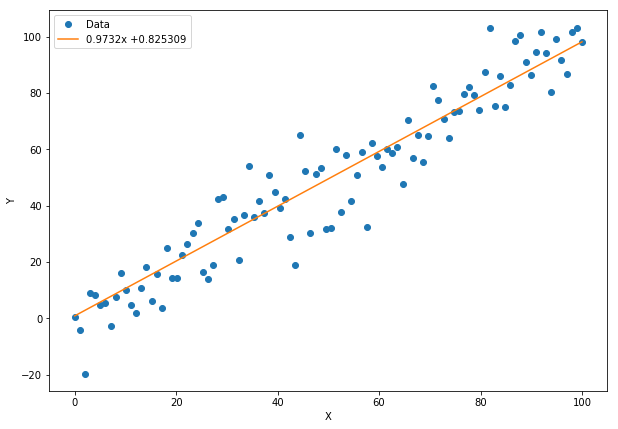

In [12]:
x_data = x.data.numpy() # 获得x包裹的数据
plt.figure(figsize = (10, 7)) #设定绘图窗口大小
xplot, = plt.plot(x_data, y.data.numpy(), 'o') # 绘制原始数据
yplot, = plt.plot(x_data, a.data.numpy() * x_data + b.data.numpy())  #绘制拟合数据
plt.xlabel('X') #更改坐标轴标注
plt.ylabel('Y') #更改坐标轴标注
str1 = str(a.data.numpy()[0]) + 'x +' + str(b.data.numpy()[0]) #图例信息
plt.legend([xplot, yplot],['Data', str1]) #绘制图例
plt.show()

### c. 测试阶段

In [13]:
x_test = Variable(torch.FloatTensor([1, 2, 10, 100, 1000])) #随便选择一些点1，2，……，1000
predictions = a.expand_as(x_test) * x_test + b.expand_as(x_test) #计算模型的预测结果
predictions #输出

Variable containing:
   1.7985
   2.7717
  10.5573
  98.1453
 974.0251
[torch.FloatTensor of size 5]